In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

from PIL import Image
import matplotlib.pyplot as plt

import copy

from pytorch_datasetloader import *

# The Discriminator

In [2]:
class Dis(nn.Module):
    
    
    def __init__(self):
        
        super().__init__()
        
        #block 1 input = 3*128*128 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=15, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        #block 2 input = 15*64*64
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=15,out_channels=50, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        #block 3 input = 50*32*32
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=50,out_channels=200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
     
        #self.drop_out = nn.Dropout()
        self.fc1 = torch.nn.Linear(200*16*16, 120)
        self.fc2 = torch.nn.Linear(120, 60)
        
        self.outlayer = nn.Sequential(
            nn.Linear(60, 1),
            nn.Sigmoid()
        )
        
        
        
    def forward(self, x):
        

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.outlayer(out)
        
        return(out)
    


In [3]:
#patch level Discriminator Used In cartoonGAN
#code: https://github.com/znxlwm/pytorch-CartoonGAN/
class Dis_patch(nn.Module):
    
    # initializers
    def __init__(self, in_nc, out_nc, nf=32):
        super(Dis_patch, self).__init__()
        self.input_nc = in_nc
        self.output_nc = out_nc
        self.nf = nf
        self.convs = nn.Sequential(
            nn.Conv2d(in_nc, nf, 3, 1, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf * 2, 3, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 2, nf * 4, 3, 1, 1),
            nn.InstanceNorm2d(nf * 4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 4, nf * 4, 3, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 4, nf * 8, 3, 1, 1),
            nn.InstanceNorm2d(nf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 8, nf * 8, 3, 1, 1),
            nn.InstanceNorm2d(nf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 8, out_nc, 3, 1, 1),
            nn.Sigmoid(),
        )

    # forward method
    def forward(self, input):

        output = self.convs(input)

        return output

# The Generator

In [4]:
#pooling for rescaling was avoided in favor of strided convolutions
#based on following paper: https://arxiv.org/pdf/1606.03498.pdf
class Gen(nn.Module):
    

    
    def __init__(self):
        
        super().__init__()
        

        self.encode = nn.Sequential(
            
            #encoding 1
            nn.Conv2d(in_channels=3,out_channels=15, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(15),
            
            #encoding 2
            nn.Conv2d(in_channels=15,out_channels=50, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(50),
            
            #encoding 3
            nn.Conv2d(in_channels=50,out_channels=200, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(200)
            
            
        )
        
        
        self.decode = nn.Sequential(
            
            #decoding 1
            nn.ConvTranspose2d(in_channels=200,out_channels=50, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(50),
            
            #decoding 2
            nn.ConvTranspose2d(in_channels=50,out_channels=15, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(15),
            
            #decoding 3
            nn.ConvTranspose2d(in_channels=15,out_channels=3, kernel_size=4, stride=2, padding=1)
        )
        
        
        
        
    def forward(self, x):
        

        out = self.encode(x)
        out = self.decode(out)
  
        return(out)




In [5]:
#pooling for rescaling was avoided in favor of strided convolutions
#based on following paper: https://arxiv.org/pdf/1606.03498.pdf
class Custom_Gen_Res(nn.Module):
    

    
    def __init__(self):
        
        super().__init__()
        

        self.encode = nn.Sequential(
            
            #encoding 1
            nn.Conv2d(in_channels=3,out_channels=15, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(15),
            
            #encoding 2
            nn.Conv2d(in_channels=15,out_channels=50, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(50),
            
            #encoding 3
            nn.Conv2d(in_channels=50,out_channels=200, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(200)
            
            
        )
        
        
        for i in range(nb):
            self.resnet_blocks.append(resnet_block(nf * 4, 3, 1, 1))
        
        
        self.decode = nn.Sequential(
            
            #decoding 1
            nn.ConvTranspose2d(in_channels=200,out_channels=50, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(50),
            
            #decoding 2
            nn.ConvTranspose2d(in_channels=50,out_channels=15, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(15),
            
            #decoding 3
            nn.ConvTranspose2d(in_channels=15,out_channels=3, kernel_size=4, stride=2, padding=1)
        )
        
        
        
        
    def forward(self, x):
        

        out = self.encode(x)
        out = self.decode(out)
  
        return(out)




# The ResNet Block

In [21]:
class resnet_block(nn.Module):
    def __init__(self, channel, kernel, stride, padding):
        super(resnet_block, self).__init__()
        self.channel = channel
        self.kernel = kernel
        self.strdie = stride
        self.padding = padding
        self.conv1 = nn.Conv2d(channel, channel, kernel, stride, padding)
        self.conv1_norm = nn.InstanceNorm2d(channel)
        self.conv2 = nn.Conv2d(channel, channel, kernel, stride, padding)
        self.conv2_norm = nn.InstanceNorm2d(channel)

    def forward(self, input):
        x = F.relu(self.conv1_norm(self.conv1(input)), True)
        x = self.conv2_norm(self.conv2(x))

        return input + x #Elementwise Sum

In [22]:
class Gen_res(nn.Module):
    # initializers
    def __init__(self, in_nc, out_nc, nf=32, nb=6):
        super(Gen_res, self).__init__()
        self.input_nc = in_nc
        self.output_nc = out_nc
        self.nf = nf
        self.nb = nb
        self.down_convs = nn.Sequential(
            nn.Conv2d(in_nc, nf, 7, 1, 3), #k7n64s1
            nn.InstanceNorm2d(nf),
            nn.ReLU(True),
            nn.Conv2d(nf, nf * 2, 3, 2, 1), #k3n128s2
            nn.Conv2d(nf * 2, nf * 2, 3, 1, 1), #k3n128s1
            nn.InstanceNorm2d(nf * 2),
            nn.ReLU(True),
            nn.Conv2d(nf * 2, nf * 4, 3, 2, 1), #k3n256s1
            nn.Conv2d(nf * 4, nf * 4, 3, 1, 1), #k3n256s1
            nn.InstanceNorm2d(nf * 4),
            nn.ReLU(True),
        )

        self.resnet_blocks = []
        for i in range(nb):
            self.resnet_blocks.append(resnet_block(nf * 4, 3, 1, 1))

        self.resnet_blocks = nn.Sequential(*self.resnet_blocks)

        self.up_convs = nn.Sequential(
            nn.ConvTranspose2d(nf * 4, nf * 2, 3, 2, 1, 1), #k3n128s1/2
            nn.Conv2d(nf * 2, nf * 2, 3, 1, 1), #k3n128s1
            nn.InstanceNorm2d(nf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(nf * 2, nf, 3, 2, 1, 1), #k3n64s1/2
            nn.Conv2d(nf, nf, 3, 1, 1), #k3n64s1
            nn.InstanceNorm2d(nf),
            nn.ReLU(True),
            nn.Conv2d(nf, out_nc, 7, 1, 3), #k7n3s1
            nn.Tanh(),
        )


    # forward method
    def forward(self, input):
        x = self.down_convs(input)
        x = self.resnet_blocks(x)
        output = self.up_convs(x)

        return output

# VGG19 Feature-map Extractor

In [8]:
class VGG19(nn.Module):
    def __init__(self, init_weights=None, feature_mode=False, batch_norm=False, num_classes=1000):
        super(VGG19, self).__init__()
        self.cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
        self.init_weights = init_weights
        self.feature_mode = feature_mode
        self.batch_norm = batch_norm
        self.num_clases = num_classes
        self.features = self.make_layers(self.cfg, batch_norm)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if not init_weights == None:
            self.load_state_dict(torch.load(init_weights))

    def make_layers(self, cfg, batch_norm=False):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.feature_mode:
            module_list = list(self.features.modules())
            for l in module_list[1:27]:                 # conv4_4
                x = l(x)
        if not self.feature_mode:
            x = x.view(x.size(0), -1)
            x = self.classifier(x)

        return x

# Initialize Generetor and Discriminator

In [9]:
#using cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# D = Dis()
D = Dis_patch(3,1)
D = D.to(device)

G = Gen_res(3,3)
G = G.to(device)


VGG = VGG19('Pretrained Models/vgg19-dcbb9e9d.pth',feature_mode=True)
VGG = VGG.to(device)


cuda:0


# Selecting Optimizer 

In [12]:
criterion = nn.BCELoss().to(device)
L1_loss = nn.L1Loss().to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# Reconstruction Workload

## Loading Prexisting Generator

In [10]:
batch_size = 50

#G = Gen_res(3,3)
#G.load_state_dict(torch.load('GAN_OUTs/Reconstructing_generator_gen.pkl'))

G = Gen()
G.load_state_dict(torch.load('GAN_OUTs/Reconstructing_generator_gen.pkl'))
G = G.to(device)


g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)


path = 'RealFaces_400'
trainloader_nonpixel, validloader_nonpixel = get_loaders(path,batch_size=batch_size,num_workers=0)




NameError: name 'batch_size_Realpix' is not defined

## Pre-Train Reconstruction Only

In [ ]:
num_epochs = 2000
recon_loss_list = []

for epoch in range(num_epochs):
    
    trainiter_nonpixel = iter(trainloader_nonpixel)
    #trainloader_pixel = iter(trainloader_pixel)
    
    for i in range(5):
        
        inputImages, input_lbls = trainiter_nonpixel.next()
        inputImages = inputImages.to(device)

        fake_images = G(inputImages)
        
        inputImages_fmap = VGG((inputImages + 1) / 2)
        G_fmap = VGG((fake_images + 1) / 2)
        
        Recon_loss = 10 * L1_loss(G_fmap, inputImages_fmap.detach())
        
        g_optimizer.zero_grad()
        Recon_loss.backward()
        g_optimizer.step()
      
    if (epoch+1) % 10 == 0:
        print('Epoch No [{}/{}] Generator Loss: {:.4f}'.format(epoch+1,num_epochs,Recon_loss.item()))
        #appending loss every 10 epochs
        recon_loss_list.append(Recon_loss.item())
    
        if (epoch+1) % 100 == 0:
        # Save fake images
            fake_images = fake_images.view(fake_images.size(0), 3, 128, 128)
            save_image(fake_images.data, 'images/GAN_IO/fakes/fake_images-%d.png' %(epoch+1))



#Save Generator
torch.save(G.state_dict(), 'GAN_OUTs/Reconstructing_generator_gen.pkl')


## Testing Reconstruction On Different Dataset

In [25]:
path = 'PixelFaces_400'
im_loader, _ = get_loaders(path,batch_size=batch_size_Realpix,num_workers=0)

testiter = iter(im_loader)

testImages, _ = testiter.next()
testImages = testImages.to(device)


output = G(testImages)

fake_images = output.view(output.size(0), 3, 128, 128)
save_image(fake_images.data, 'images/GAN_IO/sample_outputs/recon_sample.png')

testImages = testImages.view(testImages.size(0), 3, 128, 128)
save_image(testImages.data, 'images/GAN_IO/sample_outputs/recon_input.png')



400 images from the dataset


# DCGAN Training

## Loading Prexisting Generator

In [14]:
G = Gen_res(3,3)
G.load_state_dict(torch.load('GAN_OUTs/Reconstructing_generator.pkl'))

# G = Gen()
# G.load_state_dict(torch.load('GAN_OUTs/Reconstructing_generator_gen.pkl'))
G = G.to(device)

g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)


## Loading Datasets for Training DCGAN

In [15]:
batch_size_Realpix = 60
batch_size_mixed = 60
dataset_len =  400

path = 'RealFaces_400'
trainloader_nonpixel, validloader_nonpixel = get_loaders(path,batch_size=batch_size_Realpix,num_workers=0)

path = 'PixelFaces_400'
trainloader_pixel, validloader_pixel = get_loaders(path,batch_size=batch_size_mixed,num_workers=0)


trainiter_nonpixel = iter(trainloader_nonpixel)
trainIter_pixel = iter(trainloader_pixel)

400 images from the dataset
400 images from the dataset


## Training the DCGAN

In [16]:
#Patch Version

# Train the model
total_step = len(trainloader_pixel)
d_loss_list = []
g_loss_list = []
acc_list = []
num_epochs = 2500
sample_imflag = 0
imsize = 128

for epoch in range(num_epochs):
    
    trainiter_nonpixel = iter(trainloader_nonpixel)
    trainIter_pixel = iter(trainloader_pixel)
    
    for i in range(5):
        
        images, lbls = trainIter_pixel.next()
        inputImages, input_lbls = trainiter_nonpixel.next()
        
        
        images = images.to(device)
        inputImages = inputImages.to(device)
        
        labels = torch.ones(len(lbls), 1, imsize // 4, imsize // 4).to(device)
        
        # Run the forward pass
        real_classification = D(images)        
        
        fake_images = G(inputImages)
        fake_classification = D(fake_images.detach())
        
        fake_lbls = torch.zeros(len(input_lbls), 1, imsize // 4, imsize // 4).to(device)
        
        d_loss_real = criterion(real_classification, labels)
        d_loss_fake = criterion(fake_classification, fake_lbls)
        d_loss = d_loss_real + d_loss_fake
        

        # Backprop and perform Adam optimisation for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        
        #Discriminator
        fake_lbls_duped = torch.ones(len(input_lbls), 1, imsize // 4, imsize // 4).to(device)
        fake_lbls_duped = fake_lbls_duped.to(device)
   
        fake_images = G(inputImages)
        fake_classification = D(fake_images)
    
        #this loss denotes how well the generator duped/tricked the discriminator
        g_loss = criterion(fake_classification, fake_lbls_duped)
        
        
        inputImages_fmap = VGG((inputImages + 1) / 2)
        G_fmap = VGG((fake_images + 1) / 2)   
        Recon_loss =  L1_loss(G_fmap, inputImages_fmap.detach())
        
        
        g_loss = g_loss + 1.5 * Recon_loss
        
        
        # Backprop and perform Adam optimisation for generator
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
      
    if (epoch+1) % 10 == 0:
        print('Epoch No [{}/{}] Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(epoch+1,num_epochs,d_loss.item(),g_loss.item()))
        #appending loss every 10 epochs
        d_loss_list.append(d_loss.item())
        g_loss_list.append(g_loss.item())
        
        # Save fake images
        fake_images = fake_images.view(fake_images.size(0), 3, imsize, imsize)
        save_image(fake_images.data, 'images/GAN_IO/fakes/fake_images-%d.png' %(epoch+1))
        
        
        # Save input images
        if sample_imflag == 0:
            inputImages = inputImages.view(inputImages.size(0), 3, imsize, imsize)
            save_image(inputImages.data, 'images/GAN_IO/input_images/inputImages-%d.png' %(epoch+1))
            sample_imflag = 1
    

    


Epoch No [10/2500] Discriminator Loss: 0.9452, Generator Loss: 3.1581
Epoch No [20/2500] Discriminator Loss: 1.0786, Generator Loss: 2.4713
Epoch No [30/2500] Discriminator Loss: 1.0106, Generator Loss: 2.7925
Epoch No [40/2500] Discriminator Loss: 1.4354, Generator Loss: 3.3082
Epoch No [50/2500] Discriminator Loss: 1.2975, Generator Loss: 2.9867
Epoch No [60/2500] Discriminator Loss: 1.0279, Generator Loss: 2.4343
Epoch No [70/2500] Discriminator Loss: 1.2296, Generator Loss: 2.2258
Epoch No [80/2500] Discriminator Loss: 1.0347, Generator Loss: 2.4107
Epoch No [90/2500] Discriminator Loss: 1.0662, Generator Loss: 2.3212
Epoch No [100/2500] Discriminator Loss: 1.2252, Generator Loss: 2.7139
Epoch No [110/2500] Discriminator Loss: 1.2025, Generator Loss: 2.0792
Epoch No [120/2500] Discriminator Loss: 1.2041, Generator Loss: 2.1457
Epoch No [130/2500] Discriminator Loss: 1.1422, Generator Loss: 2.2225
Epoch No [140/2500] Discriminator Loss: 1.3630, Generator Loss: 2.6724
Epoch No [150/2

KeyboardInterrupt: 

# DCGAN Training

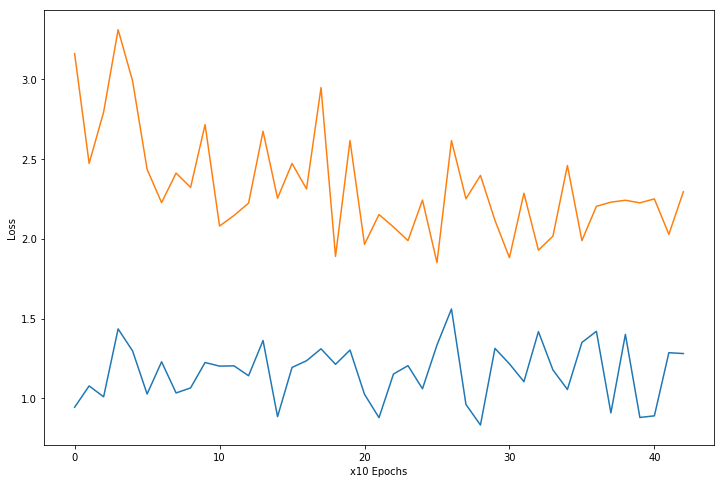

In [17]:
#GANs are saved
torch.save(G.state_dict(), 'GAN_OUTs/DCGANPatchRes_reconinited_CartoonGAN.pkl')
torch.save(D.state_dict(), 'GAN_OUTs/DCGANPatchRes_reconinited_CartoonGAN.pkl')

plt.figure(figsize=[12,8])
plt.plot(d_loss_list)
plt.plot(g_loss_list)
plt.ylabel('Loss')
plt.xlabel('x10 Epochs')
plt.savefig('images/GAN_LOSS_PLOT/GAN_Loss.png')



# Load And Inference

In [19]:
G = Gen()
G = G.to(device)
G.load_state_dict(torch.load('GAN_OUTs/DCGAN1_generator.pkl'))


batch_size = 10
path = 'RealFaces_350'
trainloader_pixel, _ = get_loaders(path,split_perc=1.0,batch_size=batch_size,num_workers=0)

testImages = iter(trainloader_pixel).next()

testimg = testImages[0].to(device)
print(testimg.shape)

output = G(testimg)

fake_images = output.view(output.size(0), 3, 128, 128)
f = fake_images.detach().cpu().numpy()
save_image(fake_images.data, 'images/GAN_IO/CustomDCGAN_output.png')

testImages = testimg.view(testimg.size(0), 3, 128, 128)
t = testImages.detach().cpu().numpy()
save_image(testimg.data, 'images/GAN_IO/CustomDCGAN_input.png')

350 images from the dataset
torch.Size([10, 3, 128, 128])


In [23]:
G = Gen_res(3,3)
G = G.to(device)
G.load_state_dict(torch.load('GAN_OUTs/DCGANPatch_generator.pkl'))


batch_size = 10
path = 'RealFaces_350'
trainloader_pixel, _ = get_loaders(path,split_perc=1.0,batch_size=batch_size,num_workers=0)

testImages = iter(trainloader_pixel).next()

testimg = testImages[0].to(device)
print(testimg.shape)

output = G(testimg)

fake_images = output.view(output.size(0), 3, 128, 128)
f = fake_images.detach().cpu().numpy()
save_image(fake_images.data, 'images/GAN_IO/CartoonGAN_output.png')

testImages = testimg.view(testimg.size(0), 3, 128, 128)
t = testImages.detach().cpu().numpy()
save_image(testimg.data, 'images/GAN_IO/CartoonGAN_input.png')

RuntimeError: Error(s) in loading state_dict for Gen_res:
	Missing key(s) in state_dict: "down_convs.0.weight", "down_convs.0.bias", "down_convs.3.weight", "down_convs.3.bias", "down_convs.4.weight", "down_convs.4.bias", "down_convs.7.weight", "down_convs.7.bias", "down_convs.8.weight", "down_convs.8.bias", "resnet_blocks.0.conv1.weight", "resnet_blocks.0.conv1.bias", "resnet_blocks.0.conv2.weight", "resnet_blocks.0.conv2.bias", "resnet_blocks.1.conv1.weight", "resnet_blocks.1.conv1.bias", "resnet_blocks.1.conv2.weight", "resnet_blocks.1.conv2.bias", "resnet_blocks.2.conv1.weight", "resnet_blocks.2.conv1.bias", "resnet_blocks.2.conv2.weight", "resnet_blocks.2.conv2.bias", "resnet_blocks.3.conv1.weight", "resnet_blocks.3.conv1.bias", "resnet_blocks.3.conv2.weight", "resnet_blocks.3.conv2.bias", "resnet_blocks.4.conv1.weight", "resnet_blocks.4.conv1.bias", "resnet_blocks.4.conv2.weight", "resnet_blocks.4.conv2.bias", "resnet_blocks.5.conv1.weight", "resnet_blocks.5.conv1.bias", "resnet_blocks.5.conv2.weight", "resnet_blocks.5.conv2.bias", "up_convs.0.weight", "up_convs.0.bias", "up_convs.1.weight", "up_convs.1.bias", "up_convs.4.weight", "up_convs.4.bias", "up_convs.5.weight", "up_convs.5.bias", "up_convs.8.weight", "up_convs.8.bias". 
	Unexpected key(s) in state_dict: "encode.0.weight", "encode.0.bias", "encode.1.weight", "encode.1.bias", "encode.1.running_mean", "encode.1.running_var", "encode.1.num_batches_tracked", "encode.2.weight", "encode.2.bias", "encode.3.weight", "encode.3.bias", "encode.3.running_mean", "encode.3.running_var", "encode.3.num_batches_tracked", "encode.4.weight", "encode.4.bias", "encode.5.weight", "encode.5.bias", "encode.5.running_mean", "encode.5.running_var", "encode.5.num_batches_tracked", "decode.0.weight", "decode.0.bias", "decode.1.weight", "decode.1.bias", "decode.1.running_mean", "decode.1.running_var", "decode.1.num_batches_tracked", "decode.2.weight", "decode.2.bias", "decode.3.weight", "decode.3.bias", "decode.3.running_mean", "decode.3.running_var", "decode.3.num_batches_tracked", "decode.4.weight", "decode.4.bias". 